Owner: Azizha Zeinita

Title: Transfer Learning to Increase Image Classification Accuracy in CNN Model using Keras: VGG-16, RESNET-50, and EfficientNet Pretrained-Model

Method:
* Base model: CNN with 3 convolutional+pooling layers and ANN layer with 2 hidden layers
* Pre-trained VGG16 model
* Pre-trained Resnet-50 
* Pre-trained EfficientNet-B7

Dataset: ImageNet subset (Imagenette)

In [56]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os

import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout, InputLayer
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing import image_dataset_from_directory

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50, EfficientNetB7 
from keras.utils import to_categorical 

In [80]:
# Creating a generator to load train and val data
img_generator = ImageDataGenerator()
train = img_generator.flow_from_directory("imagenette/train/", class_mode="categorical", target_size=(224, 224), shuffle=False, batch_size=32)
val = img_generator.flow_from_directory("imagenette/val/", class_mode="categorical", target_size=(224, 224), shuffle=False, batch_size=32)


Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


## 1. Base CNN Model

In [81]:
# Building a sequential model
model = Sequential([    
    # 1st conv layer
    # Initiate input_shape, declare padding param for adding layers of zeros to input images
    Conv2D(25, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    
    # 2nd conv layer
    Conv2D(50, (5, 5), activation='relu', strides=(1, 1), padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    BatchNormalization(), # To maintain the mean output close to 0 and the output standard deviation close to 1
    
    # 3rd conv layer
    Conv2D(70, (7, 7), activation='relu', strides=(2, 2), padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    BatchNormalization(),
    
    # ANN (fully connected) layer
    ## Fully connected input layer
    Flatten(),
    ## Fully connected hidden layer (using regularization and dropout to prevent overfitting)
    Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3), 
    ## Fully connected output layer
    Dense(units=10, activation='softmax'), 
])

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [82]:
# fit on data for 10 epochs

history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
74/74 [==============================] - 715s 10s/step - loss: 3.4817 - accuracy: 0.0843 - val_loss: 2.7920 - val_accuracy: 0.1368
Epoch 2/10
74/74 [==============================] - 628s 8s/step - loss: 2.7351 - accuracy: 0.1028 - val_loss: 2.6932 - val_accuracy: 0.1294
Epoch 3/10
74/74 [==============================] - 640s 9s/step - loss: 2.6955 - accuracy: 0.0602 - val_loss: 2.6518 - val_accuracy: 0.1320
Epoch 4/10
74/74 [==============================] - 713s 10s/step - loss: 2.6576 - accuracy: 0.0724 - val_loss: 2.6304 - val_accuracy: 0.1192
Epoch 5/10
74/74 [==============================] - 496s 7s/step - loss: 2.6186 - accuracy: 0.0938 - val_loss: 2.5483 - val_accuracy: 0.1590
Epoch 6/10
74/74 [==============================] - 1084s 15s/step - loss: 2.5873 - accuracy: 0.1191 - val_loss: 2.5228 - val_accuracy: 0.1648
Epoch 7/10
74/74 [==============================] - 4860s 66s/step - loss: 2.5421 - accuracy: 0.1174 - val_loss: 2.5272 - val_accuracy: 0.1850
Epoch 8

In [83]:
# Save the model
model.save('imagenette_model')

INFO:tensorflow:Assets written to: imagenette_model/assets


INFO:tensorflow:Assets written to: imagenette_model/assets


In [84]:
# Model Evaluation
train_loss, train_acc = model.evaluate(train)
print(train_loss, train_acc)

val_loss, val_acc = model.evaluate(val)
print(val_loss, val_acc)


74/74 [==============================] - 200s 3s/step - loss: 2.4631 - accuracy: 0.1805
2.46309494972229 0.18048368394374847
31/31 [==============================] - 125s 4s/step - loss: 2.4943 - accuracy: 0.1462
2.494276523590088 0.14624203741550446


## 2. Pre-trained VGG-16

In [4]:
# Make a pretrained model VGG-16
# Set include_top as False to remove the fully connected layer 
vgg16_pretrained_model = VGG16(include_top=False,
                         weights='imagenet') 

vgg16_pretrained_model.summary()

2023-01-29 23:16:34.100864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [8]:
# Extracting features 
x_train_vgg16 = vgg16_pretrained_model.predict(train) 
x_val_vgg16 = vgg16_pretrained_model.predict(val)


31/31 [==============================] - 1072s 34s/step


In [9]:
# Converting target value to categorical
y_train_vgg16 = to_categorical(train.labels) 
y_val_vgg16 = to_categorical(val.labels)

In [21]:
# Make a sequential model
vgg16_model = Sequential()
vgg16_model.add(Flatten(input_shape=(7, 7, 512)))
vgg16_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
vgg16_model.add(Dropout(0.5))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
vgg16_model.add(Dropout(0.5))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dense(10, activation='softmax'))

vgg16_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                      

In [15]:
# Compile model
vgg16_model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='adam')


In [16]:
# Fit the model
vgg16_history = vgg16_model.fit(x_train_vgg16, y_train_vgg16, epochs=10, validation_data=(x_val_vgg16, y_val_vgg16), batch_size=128)


Epoch 1/10
74/74 [==============================] - 13s 161ms/step - loss: 2.0559 - accuracy: 0.8658 - val_loss: 1.7086 - val_accuracy: 0.9358
Epoch 2/10
74/74 [==============================] - 10s 132ms/step - loss: 1.4044 - accuracy: 0.9678 - val_loss: 1.2961 - val_accuracy: 0.9401
Epoch 3/10
74/74 [==============================] - 11s 147ms/step - loss: 1.0520 - accuracy: 0.9822 - val_loss: 1.0827 - val_accuracy: 0.9417
Epoch 4/10
74/74 [==============================] - 12s 167ms/step - loss: 0.8856 - accuracy: 0.9815 - val_loss: 0.9969 - val_accuracy: 0.9358
Epoch 5/10
74/74 [==============================] - 13s 173ms/step - loss: 0.8400 - accuracy: 0.9811 - val_loss: 1.0009 - val_accuracy: 0.9282
Epoch 6/10
74/74 [==============================] - 15s 205ms/step - loss: 0.8590 - accuracy: 0.9785 - val_loss: 1.0539 - val_accuracy: 0.9231
Epoch 7/10
74/74 [==============================] - 16s 218ms/step - loss: 0.8269 - accuracy: 0.9791 - val_loss: 1.0001 - val_accuracy: 0.9299

In [59]:
# Save the model
vgg16_model.save('imagenette_model_vgg16')

INFO:tensorflow:Assets written to: imagenette_model_vgg16/assets


In [22]:
vgg16_train_loss, vgg16_train_acc = vgg16_model.evaluate(x_train_vgg16, y_train_vgg16)
print(vgg16_train_loss, vgg16_train_acc)

vgg16_val_loss, vgg16_val_acc = vgg16_model.evaluate(x_val_vgg16, y_val_vgg16)
print(vgg16_val_loss, vgg16_val_acc)

296/296 [==============================] - 7s 22ms/step - loss: 0.8393 - accuracy: 0.9970
0.8393310308456421 0.9970429539680481
123/123 [==============================] - 3s 23ms/step - loss: 1.0697 - accuracy: 0.9282
1.0696783065795898 0.928152859210968


## 3. RESNET-50

In [35]:
# Make a pretrained model
resnet50_pretrained_model = ResNet50(
                            include_top=False,
                            weights="imagenet")

resnet50_pretrained_model.summary()

94765736/94765736 [==============================] - 92s 1us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_6[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                         

In [36]:
# extract features 
x_train_resnet50 = resnet50_pretrained_model.predict(train) 
x_val_resnet50 = resnet50_pretrained_model.predict(val)

31/31 [==============================] - 3454s 83s/step


In [37]:
# Convert target value to categorical
y_train_resnet50 = to_categorical(train.labels) 
y_val_resnet50 = to_categorical(val.labels)

In [38]:
# Make a sequential model
resnet50_model = Sequential()
resnet50_model.add(Flatten(input_shape=(7, 7, 2048)))
resnet50_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
resnet50_model.add(Dropout(0.5))
resnet50_model.add(BatchNormalization())
resnet50_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
resnet50_model.add(Dropout(0.5))
resnet50_model.add(BatchNormalization())
resnet50_model.add(Dense(10, activation='softmax'))

resnet50_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_12 (Dense)            (None, 512)               51380736  
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                      

In [39]:
# Compile model
resnet50_model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='adam')


In [40]:
# Fit the model
resnet50_history = resnet50_model.fit(x_train_resnet50, y_train_resnet50, epochs=10, validation_data=(x_val_resnet50, y_val_resnet50), batch_size=128)


Epoch 1/10
74/74 [==============================] - 62s 814ms/step - loss: 2.6144 - accuracy: 0.8820 - val_loss: 2.0343 - val_accuracy: 0.9462
Epoch 2/10
74/74 [==============================] - 61s 824ms/step - loss: 1.6306 - accuracy: 0.9591 - val_loss: 1.4353 - val_accuracy: 0.9485
Epoch 3/10
74/74 [==============================] - 62s 831ms/step - loss: 1.2356 - accuracy: 0.9702 - val_loss: 1.2399 - val_accuracy: 0.9427
Epoch 4/10
74/74 [==============================] - 67s 901ms/step - loss: 1.1314 - accuracy: 0.9679 - val_loss: 1.2114 - val_accuracy: 0.9516
Epoch 5/10
74/74 [==============================] - 67s 901ms/step - loss: 1.2105 - accuracy: 0.9635 - val_loss: 1.3071 - val_accuracy: 0.9445
Epoch 6/10
74/74 [==============================] - 69s 934ms/step - loss: 1.2172 - accuracy: 0.9641 - val_loss: 1.3403 - val_accuracy: 0.9445
Epoch 7/10
74/74 [==============================] - 70s 950ms/step - loss: 1.2573 - accuracy: 0.9613 - val_loss: 1.3492 - val_accuracy: 0.9475

In [60]:
# Save the model
resnet50_model.save('imagenette_model_resnet50')

INFO:tensorflow:Assets written to: imagenette_model_resnet50/assets


In [42]:
resnet50_train_loss, resnet50_train_acc = resnet50_model.evaluate(x_train_resnet50, y_train_resnet50)
print(resnet50_train_loss, resnet50_train_acc)

resnet50_val_loss, resnet50_val_acc = resnet50_model.evaluate(x_val_resnet50, y_val_resnet50)
print(resnet50_val_loss, resnet50_val_acc)

296/296 [==============================] - 29s 94ms/step - loss: 1.2623 - accuracy: 0.9838
1.2622580528259277 0.9838420152664185
123/123 [==============================] - 11s 84ms/step - loss: 1.4348 - accuracy: 0.9376
1.4348350763320923 0.9375796318054199


## 4. EfficientNet-B7

In [43]:
# Make a pretrained model
efficientnetb7_pretrained_model = EfficientNetB7(
                            include_top=False,
                            weights="imagenet")

efficientnetb7_pretrained_model.summary()

258076736/258076736 [==============================] - 114s 0us/step
Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_8[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )              

In [44]:
# extract features 
x_train_efficientnetb7 = efficientnetb7_pretrained_model.predict(train) 
x_val_efficientnetb7 = efficientnetb7_pretrained_model.predict(val)

31/31 [==============================] - 1534s 49s/step


In [46]:
# Convert target value to categorical
y_train_efficientnetb7 = to_categorical(train.labels) 
y_val_efficientnetb7 = to_categorical(val.labels)

In [50]:
# Make a sequential model
efficientnetb7_model = Sequential()
efficientnetb7_model.add(Flatten(input_shape=(7, 7, 2560)))
efficientnetb7_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
efficientnetb7_model.add(Dropout(0.5))
efficientnetb7_model.add(BatchNormalization())
efficientnetb7_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
efficientnetb7_model.add(Dropout(0.5))
efficientnetb7_model.add(BatchNormalization())
efficientnetb7_model.add(Dense(10, activation='softmax'))

efficientnetb7_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 125440)            0         
                                                                 
 dense_18 (Dense)            (None, 512)               64225792  
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_12 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_19 (Dense)            (None, 512)               262656    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                      

In [51]:
# Compile model
efficientnetb7_model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='adam')


In [52]:
# Fit the model
efficientnetb7_history = efficientnetb7_model.fit(x_train_efficientnetb7, y_train_efficientnetb7, epochs=10, validation_data=(x_val_efficientnetb7, y_val_efficientnetb7), batch_size=128)


Epoch 1/10
74/74 [==============================] - 118s 2s/step - loss: 2.6706 - accuracy: 0.9379 - val_loss: 2.0154 - val_accuracy: 0.9855
Epoch 2/10
74/74 [==============================] - 108s 1s/step - loss: 1.5362 - accuracy: 0.9867 - val_loss: 1.2296 - val_accuracy: 0.9875
Epoch 3/10
74/74 [==============================] - 107s 1s/step - loss: 1.1047 - accuracy: 0.9900 - val_loss: 1.0375 - val_accuracy: 0.9801
Epoch 4/10
74/74 [==============================] - 111s 1s/step - loss: 1.0437 - accuracy: 0.9860 - val_loss: 1.2318 - val_accuracy: 0.9832
Epoch 5/10
74/74 [==============================] - 82s 1s/step - loss: 1.2964 - accuracy: 0.9853 - val_loss: 1.4283 - val_accuracy: 0.9829
Epoch 6/10
74/74 [==============================] - 77s 1s/step - loss: 1.3362 - accuracy: 0.9864 - val_loss: 1.3145 - val_accuracy: 0.9834
Epoch 7/10
74/74 [==============================] - 74s 993ms/step - loss: 1.4115 - accuracy: 0.9826 - val_loss: 1.6071 - val_accuracy: 0.9796
Epoch 8/10
74

In [61]:
# Save the model
efficientnetb7_model.save('imagenette_model_efficientnetb7')

INFO:tensorflow:Assets written to: imagenette_model_efficientnetb7/assets


In [53]:
efficientnetb7_train_loss, efficientnetb7_train_acc = efficientnetb7_model.evaluate(x_train_efficientnetb7, y_train_efficientnetb7)
print(efficientnetb7_train_loss, efficientnetb7_train_acc)

efficientnetb7_val_loss, efficientnetb7_val_acc = efficientnetb7_model.evaluate(x_val_efficientnetb7, y_val_efficientnetb7)
print(efficientnetb7_val_loss, efficientnetb7_val_acc)


296/296 [==============================] - 37s 126ms/step - loss: 1.8997 - accuracy: 0.9955
1.899719476699829 0.9954588413238525
123/123 [==============================] - 13s 99ms/step - loss: 1.9445 - accuracy: 0.9827
1.9444609880447388 0.9826751351356506


## 5. Evaluation

In [101]:
# Accuracy and Loss Comparison
data = [['Base Model',train_loss, val_loss, train_acc, val_acc],
       ['Pre-trained VGG-16',vgg16_train_loss, vgg16_val_loss, vgg16_train_acc, vgg16_val_acc],
       ['Pre-trained Resnet-16',resnet50_train_loss, resnet50_val_loss, resnet50_train_acc, resnet50_val_acc],
       ['Pre-trained EfficientNet-B7',efficientnetb7_train_loss, efficientnetb7_val_loss, efficientnetb7_train_acc, efficientnetb7_val_acc]]
df_eval = pd.DataFrame(data, columns = ['Model', 'Train Loss', 'Val Loss', 'Train Accuracy', 'Val Accuracy'])
df_eval


,Model,Train Loss,Val Loss,Train Accuracy,Val Accuracy
0,Base Model,2.463095,2.494277,0.180484,0.146242
1,Pre-trained VGG-16,0.839331,1.069678,0.997043,0.928153
2,Pre-trained Resnet-16,1.262258,1.434835,0.983842,0.937580
3,Pre-trained EfficientNet-B7,1.899719,1.944461,0.995459,0.982675


In [ ]:
# Showing how churn rate distribution in each categorical values in each columns
fig,ax = plt.subplots(4, 2, figsize=(30, 20))
for col,subplot in zip(col_cat, ax.flatten()):
    
    # Counting churn rate: churn values compared to total values in each categories
    churn = df.groupby(by=df[col]).Churn.sum()
    total = df.value_counts(col).sort_index()
    percent = round((churn/total*100),2)
    
    # Showing countplot
    a = sns.countplot(x = df[col], hue=df.Churn, ax=subplot)
    
    # Giving labels of churn rate
    a.bar_label(container=a.containers[1], labels=percent)

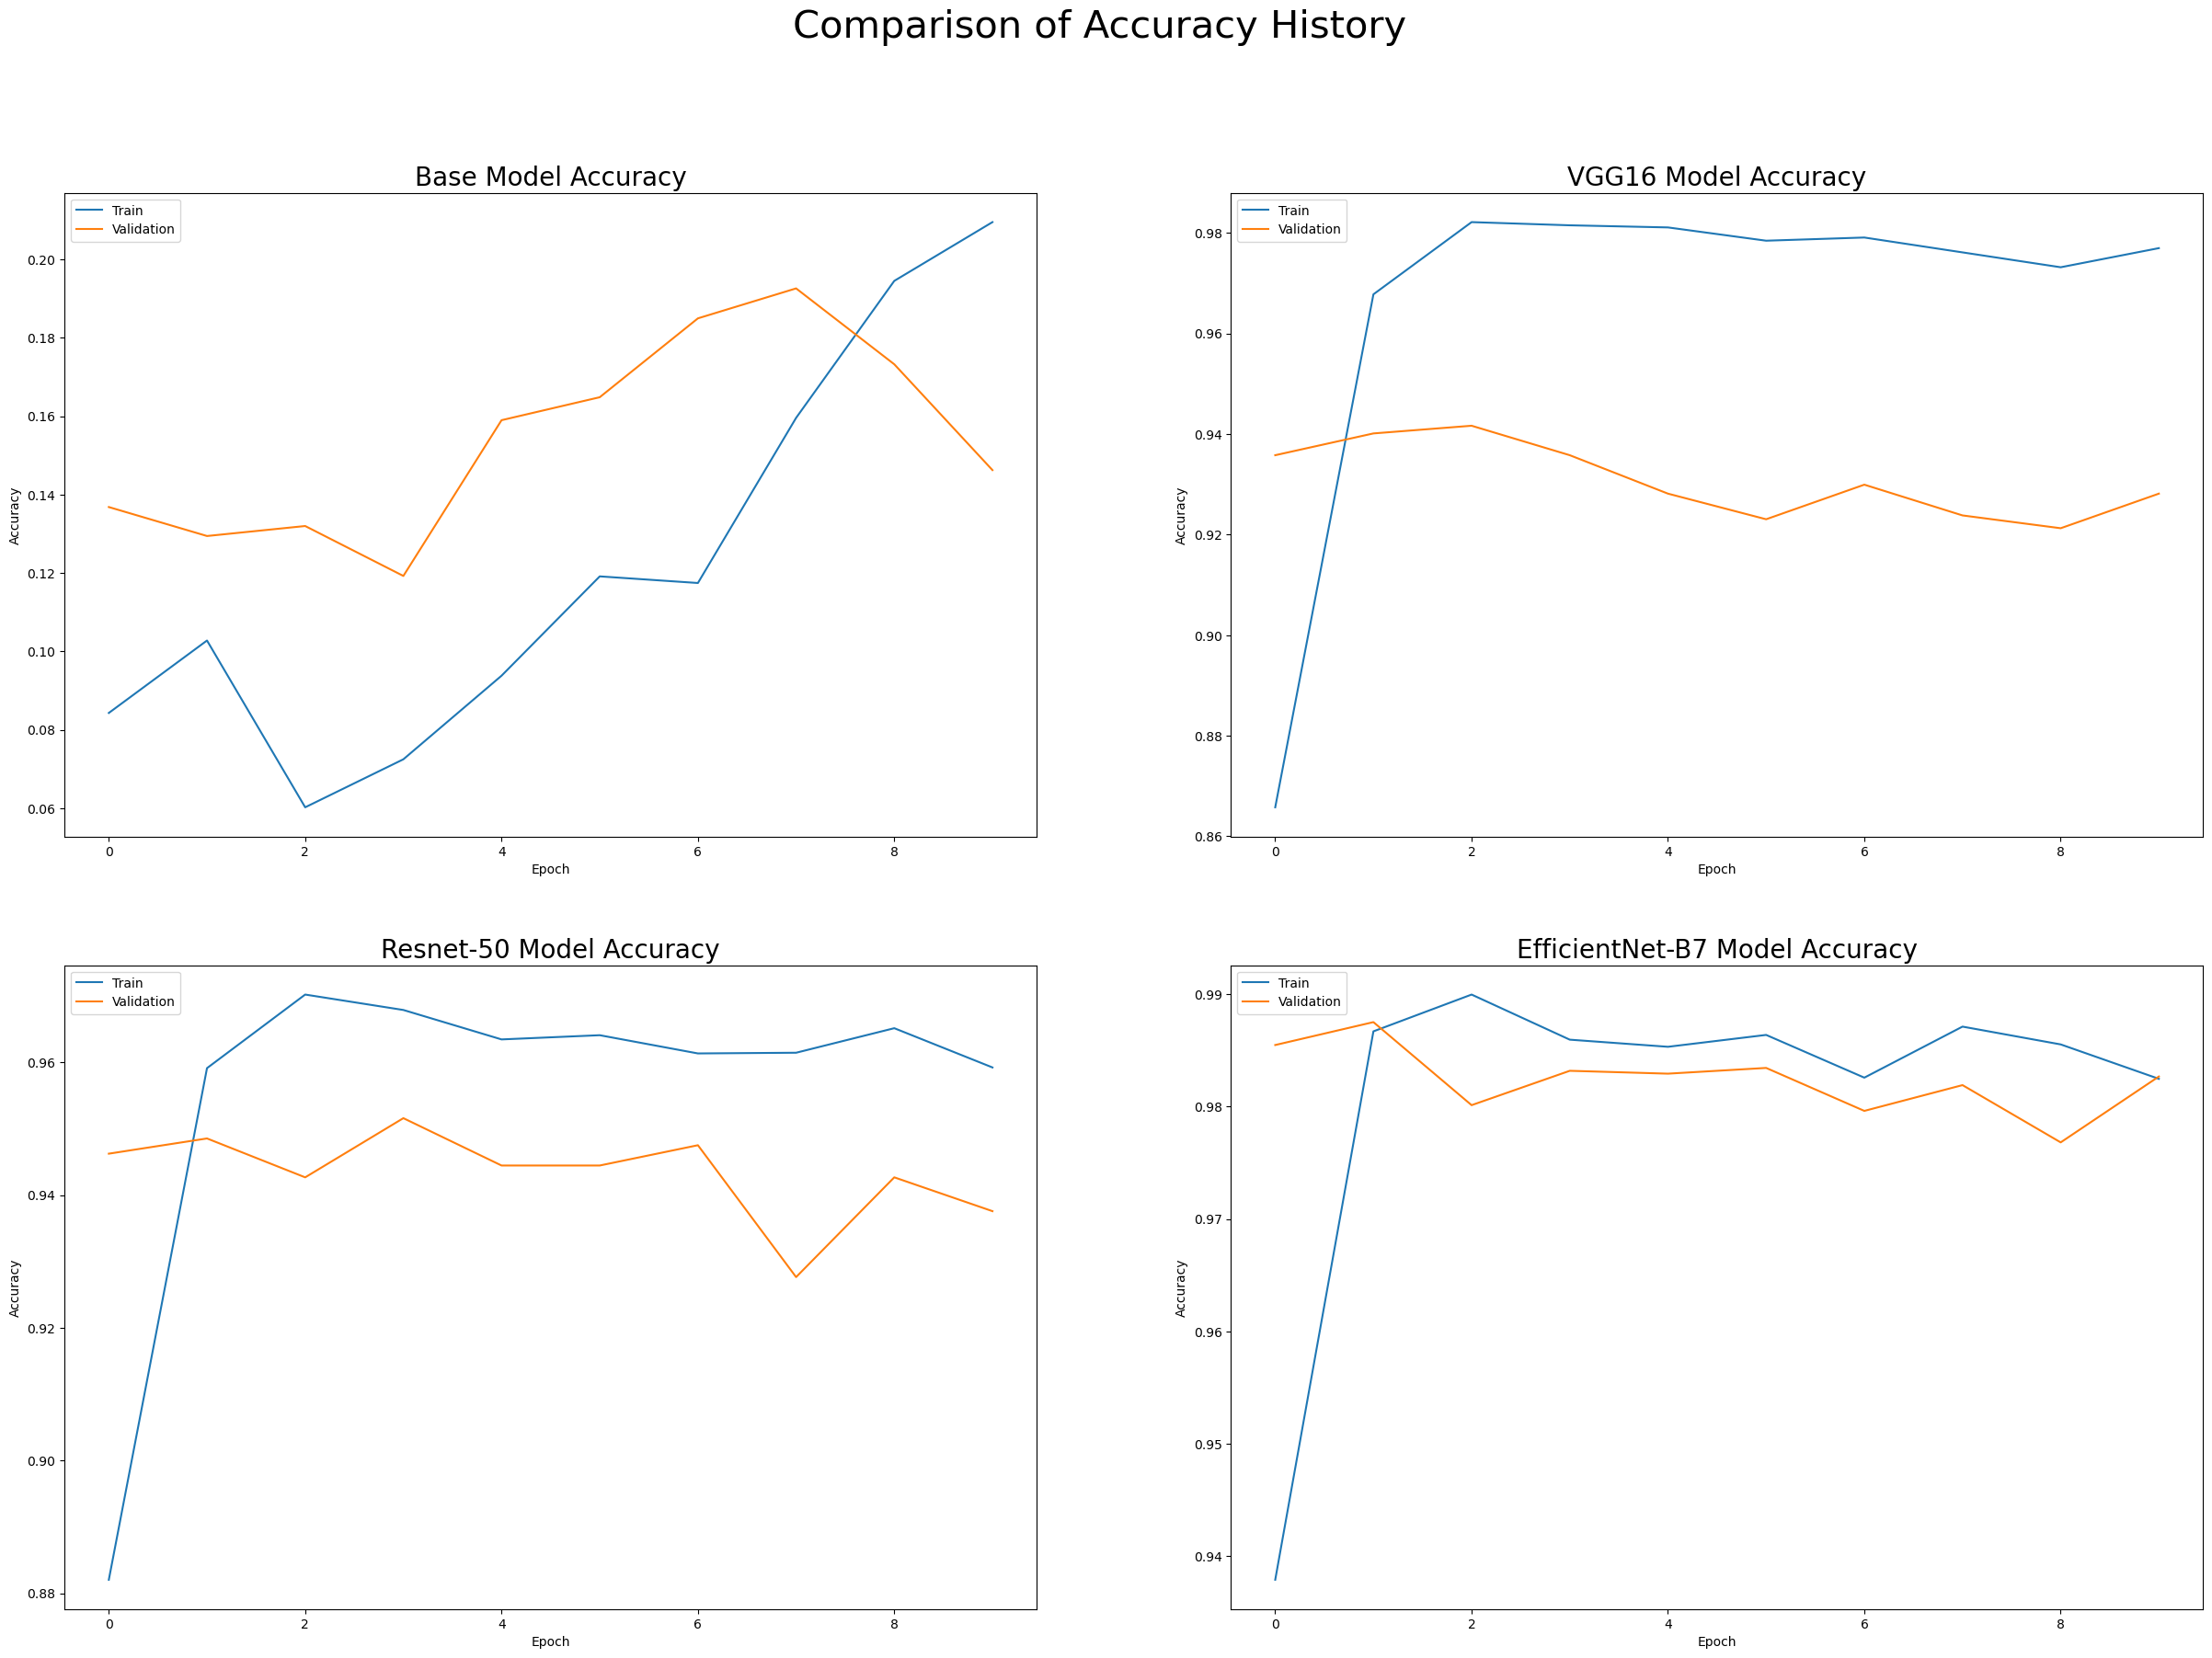

In [108]:
# History of Accuracy 
fig,ax = plt.subplots(2, 2, figsize=(30, 20))

# Summarize history for accuracy of base model
ax[0,0].plot(history.history['accuracy'])
ax[0,0].plot(history.history['val_accuracy'])
ax[0,0].set_title('Base Model Accuracy', fontsize=20)
ax[0,0].set_ylabel('Accuracy')
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend(['Train', 'Validation'], loc='upper left')

# Summarize history for accuracy of VGG16
ax[0,1].plot(vgg16_history.history['accuracy'])
ax[0,1].plot(vgg16_history.history['val_accuracy'])
ax[0,1].set_title('VGG16 Model Accuracy', fontsize=20)
ax[0,1].set_ylabel('Accuracy')
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend(['Train', 'Validation'], loc='upper left')


# Summarize history for accuracy of Resnet-50
ax[1,0].plot(resnet50_history.history['accuracy'])
ax[1,0].plot(resnet50_history.history['val_accuracy'])
ax[1,0].set_title('Resnet-50 Model Accuracy', fontsize=20)
ax[1,0].set_ylabel('Accuracy')
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend(['Train', 'Validation'], loc='upper left')

# Summarize history for accuracy of EfficientNet-B7
ax[1,1].plot(efficientnetb7_history.history['accuracy'])
ax[1,1].plot(efficientnetb7_history.history['val_accuracy'])
ax[1,1].set_title('EfficientNet-B7 Model Accuracy', fontsize=20)
ax[1,1].set_ylabel('Accuracy')
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend(['Train', 'Validation'], loc='upper left')

plt.suptitle('Comparison of Accuracy History', fontsize=30)
plt.show()

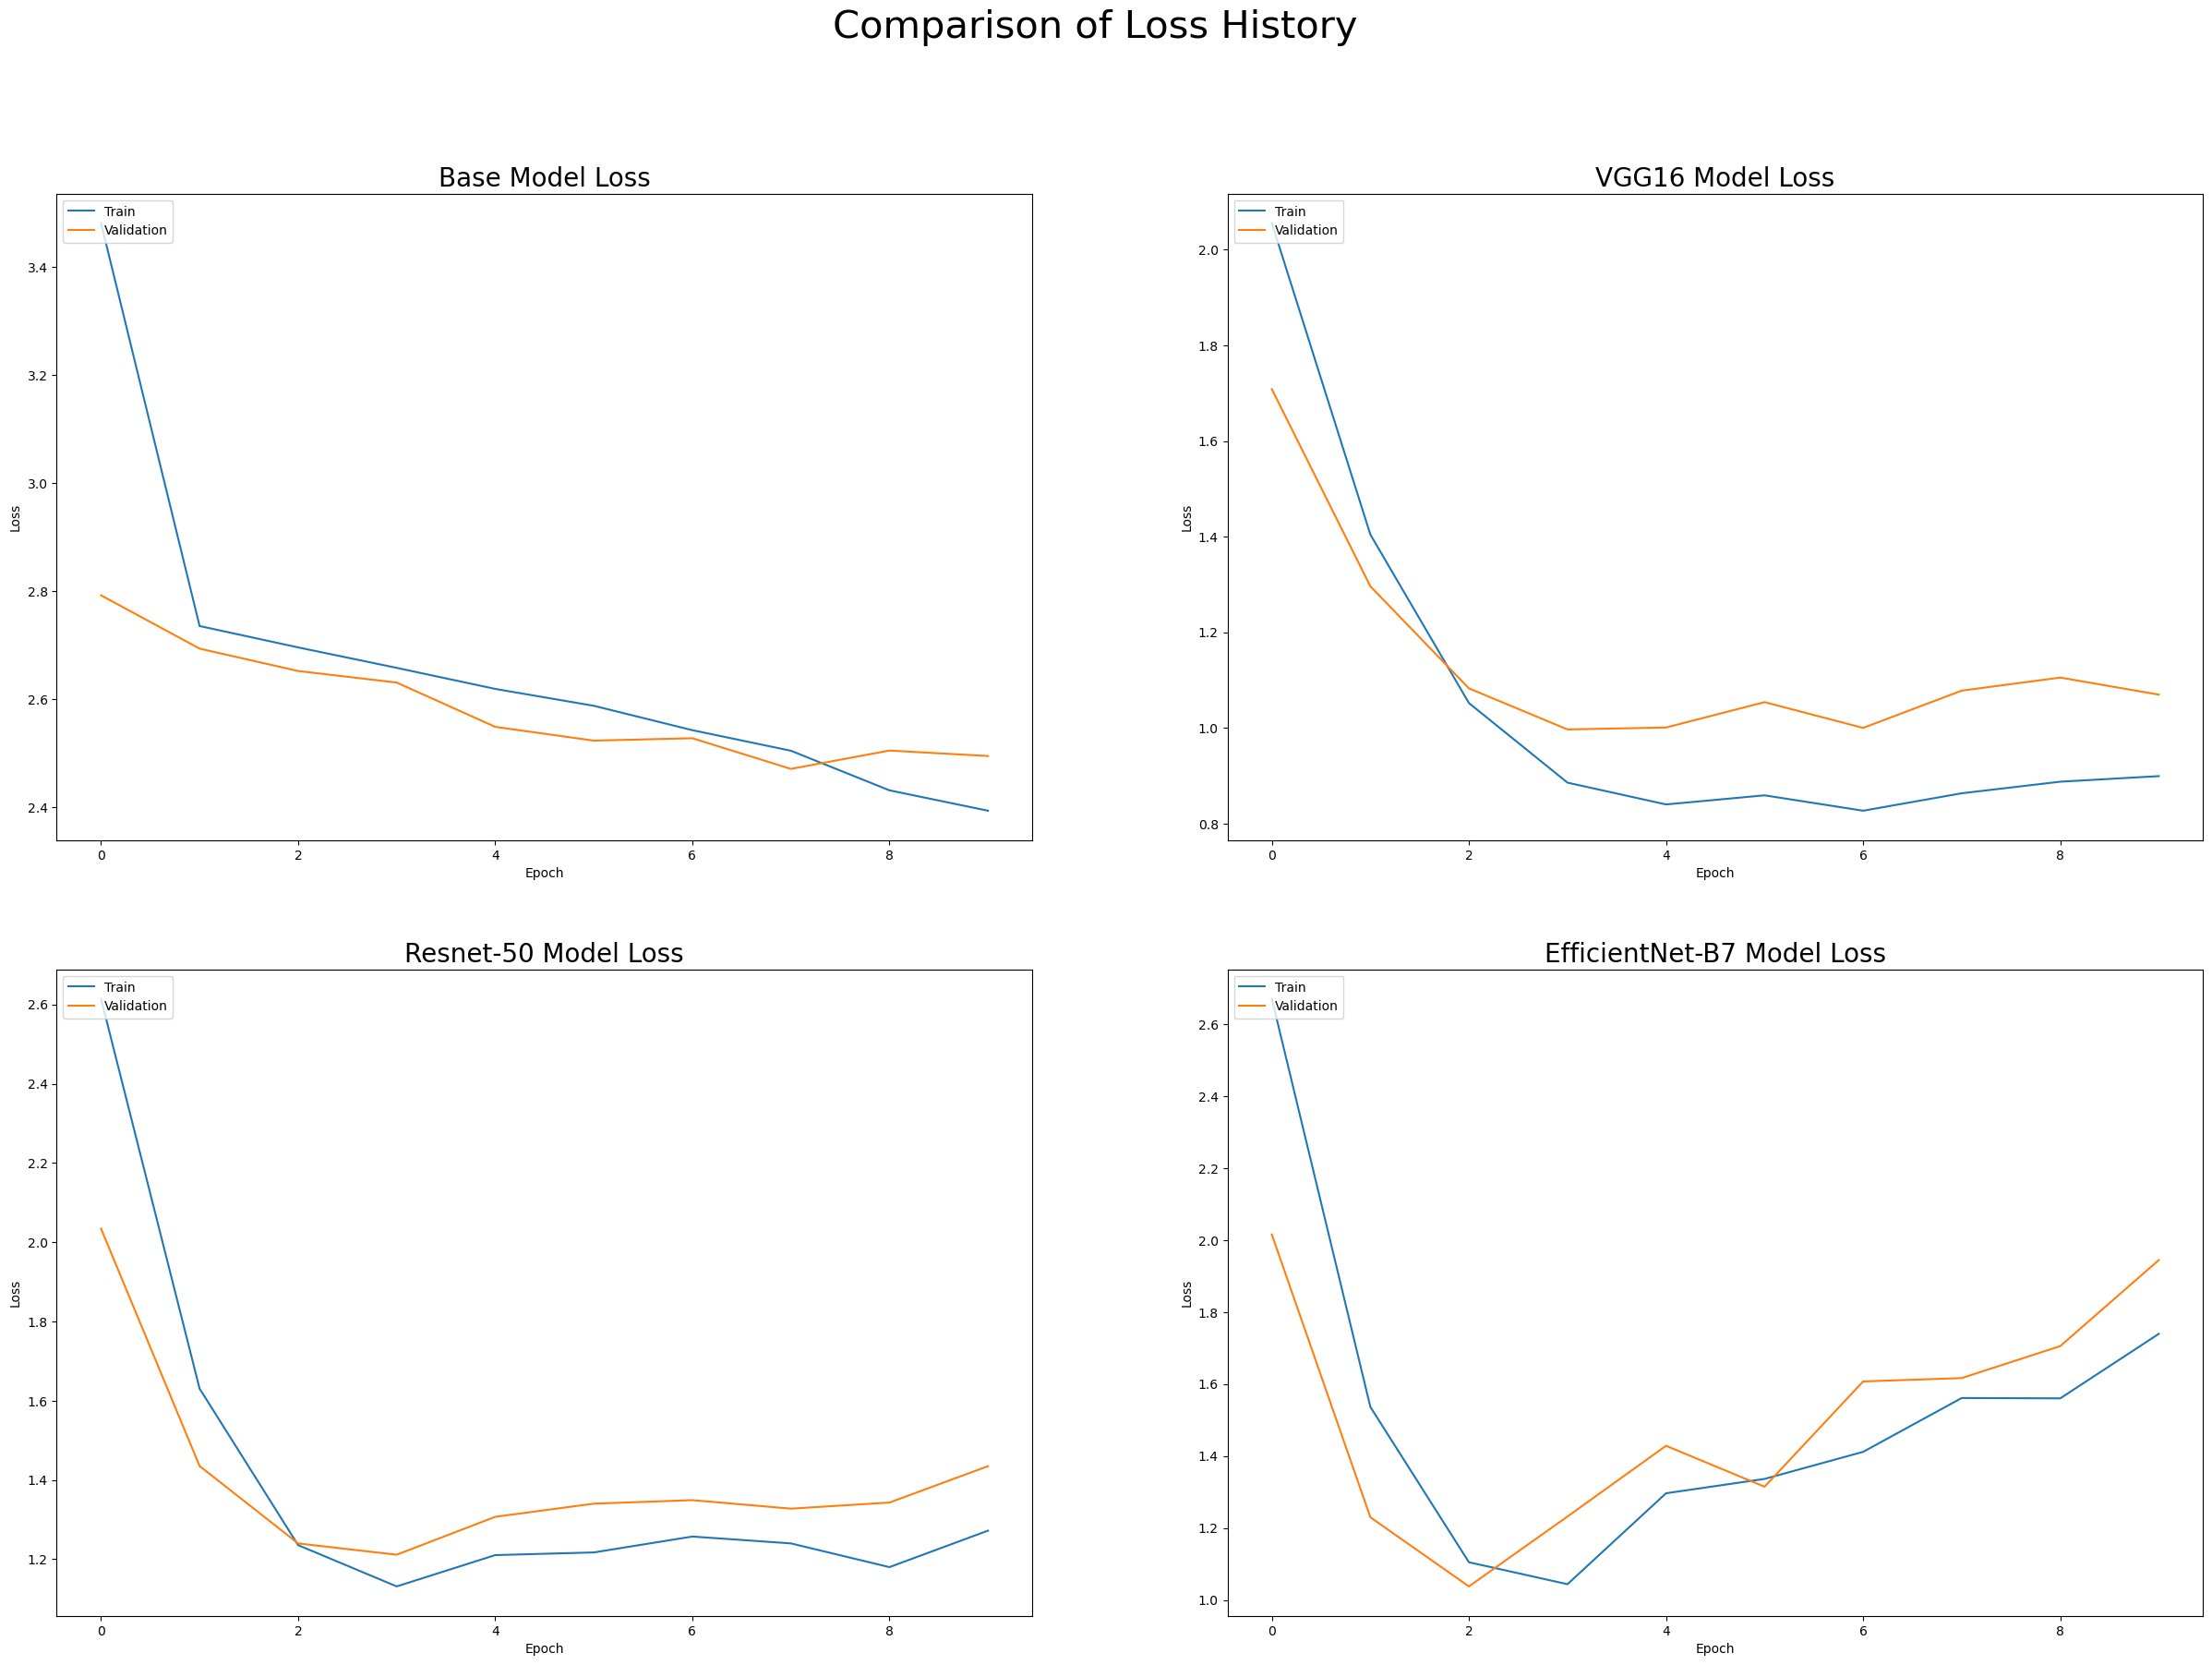

In [109]:
# History of Loss 
fig,ax = plt.subplots(2, 2, figsize=(30, 20))

# Summarize history for loss of base model
ax[0,0].plot(history.history['loss'])
ax[0,0].plot(history.history['val_loss'])
ax[0,0].set_title('Base Model Loss', fontsize=20)
ax[0,0].set_ylabel('Loss')
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss of VGG16
ax[0,1].plot(vgg16_history.history['loss'])
ax[0,1].plot(vgg16_history.history['val_loss'])
ax[0,1].set_title('VGG16 Model Loss', fontsize=20)
ax[0,1].set_ylabel('Loss')
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend(['Train', 'Validation'], loc='upper left')


# Summarize history for loss of Resnet-50
ax[1,0].plot(resnet50_history.history['loss'])
ax[1,0].plot(resnet50_history.history['val_loss'])
ax[1,0].set_title('Resnet-50 Model Loss', fontsize=20)
ax[1,0].set_ylabel('Loss')
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss of EfficientNet-B7
ax[1,1].plot(efficientnetb7_history.history['loss'])
ax[1,1].plot(efficientnetb7_history.history['val_loss'])
ax[1,1].set_title('EfficientNet-B7 Model Loss', fontsize=20)
ax[1,1].set_ylabel('Loss')
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend(['Train', 'Validation'], loc='upper left')

plt.suptitle('Comparison of Loss History', fontsize=30)
plt.show()

* **Summary:**
    * It is proved that a learning model can significantly improve a base model's accuracy
    * Based on the accuracy score, the model with EfficientNet-B7 has the best result considering its accuracy lowest accuracy differences between training and validation data, which indicates the lowest overfitting
    * VGG16 has the lowest score in training and validation data based on the loss function compared to the other models. Although EfficientNet-B7 has the best accuracy, its loss gets higher as the epoch goes higher